In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import models, transforms
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix
from PIL import Image, ImageFilter
import pandas as pd
import numpy as np
import random
import re
from timm import create_model
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from collections import OrderedDict
from torch.utils.data import Subset
import cv2
from transformers import get_cosine_schedule_with_warmup
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [30]:
class ApplyCLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8), p=0.6):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            image_np = np.array(image.convert('L'))
            cl = self.clahe.apply(image_np)
            cl = np.stack([cl]*3, axis=-1)
            return Image.fromarray(cl)
        return image

class RandomSharpen:
    def __init__(self, factor=1.0, p=0.5):
        self.factor = factor
        self.p = p

    def __call__(self, image):
        if random.random() < self.p:
            return image.filter(ImageFilter.UnsharpMask(
                radius=2,
                percent=int(100 * self.factor),
                threshold=3
            ))
        return image

In [31]:
def compute_lab_test_statistics(df):
    """
    Computes the mean and standard deviation for each laboratory test
    based on the given DataFrame (including 'No Finding').

    Returns:
        - test_statistics: dict mapping test_name -> (mean, std)
        - unique_test_names: list of all test names in order of first occurrence
        - test_columns: list of column names matching 'Lab Test i'
        - value_columns: list of column names matching 'Lab Value i'
    """
    # Find all column pairs: "Lab Test i" and corresponding "Lab Value i"
    test_columns  = [c for c in df.columns if re.match(r'^Lab Test \d+$',  c)]
    value_columns = [c for c in df.columns if re.match(r'^Lab Value \d+$', c)]

    # Collect all non-null test entries into a single DataFrame
    rows = []
    for test_col, value_col in zip(test_columns, value_columns):
        temp = df[[test_col, value_col]].dropna()
        temp.columns = ['Test Name', 'Test Value']
        rows.append(temp)
    all_tests_df = pd.concat(rows, ignore_index=True)

    all_tests_df['Test Name'] = all_tests_df['Test Name'].str.lower()
    # Get unique test names in order of first appearance
    unique_test_names = list(OrderedDict.fromkeys(all_tests_df['Test Name']))

    # Compute mean and std for each test name
    test_statistics = {}
    for name in unique_test_names:
        vals = all_tests_df.loc[all_tests_df['Test Name'] == name, 'Test Value'].astype(float)
        if len(vals) > 0:
            mean = float(vals.mean())
            std = float(max(vals.std(), 1e-2))  # Avoid zero std
        else:
            mean, std = 0.0, 1.0
        test_statistics[name] = (mean, std)

    # Add PAD token for special purposes
    test_statistics['pad'] = (0.0, 1.0)

    return test_statistics, unique_test_names, test_columns, value_columns

In [32]:
def build_test_name_to_idx(unique_test_names, pad_token="pad"):
    #unique_test_names = [name.lower() for name in unique_test_names if name != pad_token]
    test_name_to_idx = {name: idx for idx, name in enumerate(unique_test_names)}
    test_name_to_idx[pad_token.lower()] = len(unique_test_names)
    return test_name_to_idx

In [33]:
def custom_collate(batch, top_tests_to_idx):
    """
    Custom collate function for batching samples with variable-length lab test sequences.

    Args:
        batch: List of tuples (test_sequence, label, image).
            - test_sequence: list of (test_name, value) pairs for each sample.
            - label: Tensor or value for the label.
            - image: Tensor/image for the sample.
        top_tests_to_idx: dict mapping lab test names to integer indices.

    Returns:
        labels (Tensor): Batched labels.
        images (Tensor): Batched images.
        attention_mask (Tensor[bool]): Mask indicating which tests are real (not PAD).
        test_indices (Tensor[long]): Indices of lab tests (padded).
        test_values (Tensor[float]): Values of lab tests (padded).
    """
    test_sequences, labels, images = zip(*batch)
    max_len = max(len(seq) for seq in test_sequences)

    test_indices = []
    test_values = []
    attention_masks = []

    for seq in test_sequences:
        # Pad sequence to max_len with ("PAD", 0.0)
        padded = seq + [("pad", 0.0)] * (max_len - len(seq))

        indices = []
        values = []
        mask = []

        for test_name, value in padded:
            idx = top_tests_to_idx.get(test_name, top_tests_to_idx["pad"])
            indices.append(idx)
            values.append(value)
            mask.append(1 if test_name != "pad" else 0)

        test_indices.append(indices)
        test_values.append(values)
        attention_masks.append(mask)

    test_indices_tensor = torch.tensor(test_indices, dtype=torch.long)
    test_values_tensor = torch.tensor(test_values, dtype=torch.float)
    attention_mask_tensor = torch.tensor(attention_masks, dtype=torch.bool)

    # Sanity checks
    #if torch.isnan(test_indices_tensor).any():
    #    raise ValueError("[ERROR] NaN detected in lab_test_indices!")

    #if (test_indices_tensor < 0).any():
    #    raise ValueError("[ERROR] Negative values found in lab_test_indices!")

    #if (test_indices_tensor >= len(top_tests_to_idx)).any():
    #    raise ValueError("[ERROR] Out-of-range indices detected in lab_test_indices!")

    #if torch.isnan(test_values_tensor).any():
    #    raise ValueError("[ERROR] NaN detected in lab_values!")

    #if torch.isinf(test_values_tensor).any():
    #    raise ValueError("[ERROR] Inf detected in lab_values!")

    return (
        torch.stack(labels),
        torch.stack(images),
        attention_mask_tensor,
        test_indices_tensor,
        test_values_tensor
    )

In [34]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [35]:
class SequentialLabTestDataset(Dataset):
    def __init__(self, df, label2idx, image_dir, num_classes,
             test_statistics, test_columns, value_columns, load_images=True, transform=None):        
        self.samples = []
        self.image_paths = df['image'].values
        self.image_dir = image_dir
        self.test_statistics = test_statistics
        self.test_columns = test_columns
        self.value_columns = value_columns
        self.load_images = load_images

        #assert len(test_columns) == len(value_columns), "Mismatch in lab test/value columns!"

        self.labels = []
        for _, row in df.iterrows():
            tests = []
            for test_col, value_col in zip(test_columns, value_columns):
                test_name = row[test_col]
                value = row[value_col]
                if pd.notna(test_name) and pd.notna(value):
                    test_name = str(test_name).lower() 
                    mean, std = self.test_statistics[test_name]
                    norm_value = (float(value) - mean) / (std + 1e-6)
                    tests.append((test_name, norm_value))
            if len(tests) == 0:
                tests.append(("pad", 0.0))
            self.samples.append(tests)

            findings = str(row['Finding Labels']).split('|')
            multilabel = np.zeros(num_classes)
            for finding in findings:
                finding = finding.strip()
                if finding in label2idx:
                    multilabel[label2idx[finding]] = 1

            self.labels.append(multilabel)

        self.labels = torch.tensor(np.array(self.labels), dtype=torch.float32)
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        tests = self.samples[idx]
        label = self.labels[idx]
    
        if not self.load_images:
            return tests, label, None

        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"[WARNING] Failed to load image: {image_path}. Error: {e}")
            image = Image.new('RGB', (224, 224), color=(0, 0, 0))  \

        image = self.transform(image)
        return tests, label, image


In [36]:
class LabImageEncoder(nn.Module):
    def __init__(self, output_dim=512):
        super().__init__()
        # Backbone: SEResNet-50 (from timm.create_model)
        self.backbone = create_model(
            'seresnet50',
            pretrained=True,
            features_only=False
        )

        # Freeze all parameters initially
        for param in self.backbone.parameters():
            param.requires_grad = False

        # By default allow layer4 to be trainable
        for name, param in self.backbone.named_parameters():
            if "layer4" in name:
                param.requires_grad = True

        # Projection head to map features to output_dim
        self.projection_head = self._init_embedding_layer(output_dim)

    def _init_embedding_layer(self, output_dim):
        # Remove the built-in classifier and create a new linear projection head
        in_features = self.backbone.get_classifier().in_features
        self.backbone.reset_classifier(0)
        return nn.Linear(in_features, output_dim)

    def unfreeze_layers(self, epoch):
        """
        Gradually unfreeze more layers as training progresses.
        """
        if epoch >= 1:
            for name, param in self.backbone.named_parameters():
                if "layer2" in name:
                    param.requires_grad = True
        if epoch >= 6:
            for name, param in self.backbone.named_parameters():
                if "layer3" in name:
                    param.requires_grad = True
        if epoch >= 12:
            for param in self.backbone.parameters():
                param.requires_grad = True

    def forward(self, x, return_features=False):
        """
        Forward pass through the encoder.
        Args:
            x (Tensor): Input image tensor [B, C, H, W]
            return_features (bool): If True, also return convolutional features.
        Returns:
            image_embedding (Tensor): Normalized image embedding [B, output_dim]
            conv_features (Tensor, optional): Feature map [B, C, H', W']
        """
        conv_features = self.backbone.forward_features(x) # [B, C, H, W]
        global_avg = conv_features.mean(dim=[2, 3]) # [B, C]
        image_projection = self.projection_head(global_avg)  # [B, D]
        image_embedding = F.normalize(image_projection, dim=-1)  # [B, D]

        if return_features:
            return image_embedding, conv_features
        return image_embedding

In [37]:
class LabEncoder(nn.Module):
    def __init__(self, test_name_embeddings, hidden_dim=512, fusion_mode=None, use_attention=True):
        """
        Encodes sequences of laboratory test names and values into fixed-size representations.

        Args:
            test_name_embeddings (Tensor): Pretrained embeddings for lab test names [num_tests, embedding_dim].
            hidden_dim (int): Output hidden dimension after encoding.
            fusion_mode (str): How to fuse test name and value embeddings: "sum", "concat", or "gating".
            use_attention (bool): If True, applies multi-head self-attention to fused embeddings.
        """
        super().__init__()
        self.embedding_dim = test_name_embeddings.size(1)
        self.fusion_mode = fusion_mode
        self.use_attention = use_attention

        # Embedding layer for test names (should be trained further)
        self.test_name_embedding = nn.Embedding.from_pretrained(test_name_embeddings, freeze=False)
        # Project scalar lab values to the embedding space
        self.value_proj = nn.Linear(1, self.embedding_dim)

        # Probably it was better to stay with concat
        if fusion_mode == 'sum':
            self.fusion_fn = lambda test, val: test + val

        elif fusion_mode == 'concat':
            self.concat_proj = nn.Linear(2 * self.embedding_dim, self.embedding_dim)
            self.fusion_fn = lambda test, val: self.concat_proj(torch.cat([test, val], dim=-1))

        elif fusion_mode == 'gating':
            self.gate_proj = nn.Linear(2 * self.embedding_dim, self.embedding_dim)
            def gated_fusion(test, val):
                gate_input = torch.cat([test, val], dim=-1)
                gate = torch.sigmoid(self.gate_proj(gate_input))
                return gate * test + (1 - gate) * val
            self.fusion_fn = gated_fusion

        else:
            raise ValueError(f"Unknown fusion mode: {fusion_mode}")

        # Optional self-attention over the sequence of fused embeddings. 
        if use_attention:
            self.attention = nn.MultiheadAttention(embed_dim=self.embedding_dim, num_heads=4, batch_first=True)

        # Final projection to the required hidden dimension
        self.output_proj = nn.Linear(self.embedding_dim, hidden_dim)

    def forward(self, test_ids, test_values, mask=None):
        """
        Args:
            test_ids (Tensor[long]): [B, T] Tensor with indices of test names.
            test_values (Tensor[float]): [B, T] Tensor with lab test values.
            mask (Tensor[bool], optional): [B, T] Attention mask (1 for real tokens, 0 for PAD).
        Returns:
            output (Tensor): [B, T, hidden_dim] Encoded lab test sequence.
        """
        test_embs = self.test_name_embedding(test_ids) 
        value_embs = self.value_proj(test_values.unsqueeze(-1))  
        combined = self.fusion_fn(test_embs, value_embs)  # [B, T, D]

        if self.use_attention:
            # Invert mask for key_padding_mask: True for PAD, False for valid positions
            attention_mask = ~mask if mask is not None else None
            attn_output, _ = self.attention(combined, combined, combined, key_padding_mask=attention_mask)
            combined = attn_output # [B, T, D]

        output = self.output_proj(combined) # [B, T, hidden_dim]
        return output

    def freeze(self):
        for param in self.parameters():
            param.requires_grad = False
        self.eval()
        print("[LabEncoder] frozen")

    def unfreeze(self):
        for param in self.parameters():
            param.requires_grad = True
        self.train()
        print("[LabEncoder] unfrozen")

In [38]:
class AsymmetricLoss(nn.Module):
    """
    Asymmetric Focal Loss for multilabel classification.

    Increases the contribution of hard examples, with separate focusing parameters for 
    positive (`pos_focal_strength`) and negative (`neg_focal_strength`) labels.
    Works with logits, applies sigmoid activation, and protects against log(0).

    Args:
        pos_focal_strength (float): Focusing strength for positive labels.
        neg_focal_strength (float): Focusing strength for negative labels.
        eps (float): Small value for numerical stability (prevents log(0)).
    """
    def __init__(self, pos_focal_strength=3.0, neg_focal_strength=2.0, eps=1e-8):
        super().__init__()
        self.pos_focal_strength = pos_focal_strength
        self.neg_focal_strength = neg_focal_strength
        self.eps = eps

    def forward(self, logits, targets):
        """
        Args:
            logits (Tensor): [B, C] Raw model predictions (logits).
            targets (Tensor): [B, C] Binary target labels (0 or 1).

        Returns:
            loss (Tensor): Scalar loss value.
        """
        probs = torch.sigmoid(logits) # [B, C]
        prob_pos = probs  # Probability of positive class (1)
        prob_neg = 1.0 - probs # Probability of negative class (0)

        # Standard log loss terms, with numerical stability
        log_prob_pos = targets * torch.log(prob_pos.clamp(min=self.eps))
        log_prob_neg = (1.0 - targets) * torch.log(prob_neg.clamp(min=self.eps))
        log_loss = log_prob_pos + log_prob_neg   # [B, C], standard log-loss

        # Probability of the correct class for each entry
        pt = prob_pos * targets + prob_neg * (1.0 - targets)
        # Focusing parameter (gamma) for positive and negative samples
        gamma = self.pos_focal_strength * targets + self.neg_focal_strength * (1.0 - targets)
        focal_modulation = torch.pow(1.0 - pt, gamma)

        weighted_loss = -focal_modulation * log_loss  # [B, C]
        return weighted_loss.mean()

In [39]:
class Attention(nn.Module):
    """
    Multi-head Attention module with the ability to modify attention weights
    based on:
      - Laboratory test IDs (using a learnable bias)
      - Laboratory test values

    Used to obtain a contextualized image representation by attending to the sequence of lab tests.

    Args:
        embed_dim (int): Embedding dimension for both queries and keys/values.
        num_lab_tests (int): Number of unique lab tests (for bias embedding).
        heads (int): Number of attention heads.
        dim_head (int): Dimension of each attention head.
    """
    def __init__(self, embed_dim, num_lab_tests, heads=4, dim_head=64):
        super().__init__()
        self.heads = heads
        self.scale = dim_head ** -0.5

        inner_dim = heads * dim_head
        self.to_q = nn.Linear(embed_dim, inner_dim, bias=False)
        self.to_k = nn.Linear(embed_dim, inner_dim, bias=False)
        self.to_v = nn.Linear(embed_dim, inner_dim, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, embed_dim),
            nn.Dropout(0.3)
        )

        # Learnable bias for each lab test ID (+1 for PAD)
        self.lab_test_bias = nn.Embedding(num_lab_tests + 1, 1)
        # Project lab values (scalar) to a single bias term
        self.value_proj = nn.Linear(1, 1)
        # Joint projection of (lab test bias, value bias)
        self.joint_fusion_proj = nn.Sequential(nn.Linear(2, 1), nn.Tanh())

    def forward(
        self,
        image_embeddings,    # [B, Q_len=1, D] — typically a single image vector per batch item
        lab_embeddings=None,   # [B, K_len, D] — sequence of lab test embeddings
        mask=None,             # [B, K_len] — mask for valid lab tests (1 = valid, 0 = PAD)
        lab_test_indices=None,  # [B, K_len] — indices of lab test types
        lab_values=None      # [B, K_len] — lab test scalar values
    ):

        if lab_embeddings is None:
            lab_embeddings = image_embeddings  # fallback for self-attention

        q = self.to_q(image_embeddings)
        k = self.to_k(lab_embeddings)
        v = self.to_v(lab_embeddings)

        B, Q_len, _ = q.shape
        _, K_len, _ = k.shape

        # Reshape for multi-head attention
        q = q.view(B, Q_len, self.heads, -1).transpose(1, 2)  # [B, H, Q, D_head]
        k = k.view(B, K_len, self.heads, -1).transpose(1, 2)  # [B, H, K, D_head]
        v = v.view(B, K_len, self.heads, -1).transpose(1, 2)  # [B, H, K, D_head]

        # Compute scaled dot-product attention scores
        attention_scores = torch.matmul(q, k.transpose(-1, -2)) * self.scale  # [B, H, Q, K]

        # Optionally, add lab test and value biases to attention scores
        if lab_test_indices is not None and lab_values is not None:
            test_bias = self.lab_test_bias(lab_test_indices).squeeze(-1)    # [B, K]
            value_bias = self.value_proj(lab_values.unsqueeze(-1)).squeeze(-1)   # [B, K]

            joint_input = torch.stack([test_bias, value_bias], dim=-1)    # [B, K, 2]
            test_value_bias = self.joint_fusion_proj(joint_input).squeeze(-1)  # [B, K]
            test_value_bias = torch.clamp(test_value_bias, min=-5, max=5)

            # Expand bias to all heads and queries
            test_value_bias = test_value_bias.unsqueeze(1).unsqueeze(2)    # [B, 1, 1, K]
            attention_scores = attention_scores + test_value_bias

        # Apply attention mask (if provided)
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)               # [B, 1, 1, K]
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)

        # Softmax to obtain normalized attention weights
        attention_weights = F.softmax(attention_scores, dim=-1)          # [B, H, Q, K]
        attended = torch.matmul(attention_weights, v)         # [B, H, Q, D_head]
        attended = attended.transpose(1, 2).contiguous().view(B, Q_len, -1)   # [B, Q, D_full]

        # Project output and add residual connection from the input query
        fused = self.to_out(attended)                # [B, Q, D_embed]
        output = fused + image_embeddings       # [B, Q, D_embed]

        return output

In [40]:
class CrossAttentionFusion(nn.Module):
    """
    Module for fusing image and lab test embeddings via cross-attention.
    Applies the Attention module to combine the image embedding with a sequence of lab embeddings.
    Handles missing lab data by falling back to the pure image embedding.

    Args:
        embed_dim (int): Embedding dimension for both image and lab representations.
        num_lab_tests (int): Number of unique lab test types (for the attention bias).
    """
    def __init__(self, embed_dim, num_lab_tests):
        super().__init__()
        self.attention = Attention(embed_dim=embed_dim, num_lab_tests=num_lab_tests, heads=4, dim_head=64)

    def forward(
        self,
        image_embedding,   # [B, D] or [B, 1, D]: batch of image embeddings
        lab_embeddings, # [B, T, D]: batch of lab test embeddings
        mask=None,        # [B, T]: binary mask for valid lab tests
        lab_test_indices=None,  # [B, T]: indices of lab test types
        lab_values=None  # [B, T]: lab test values
    ):

        # Just to ensure image_embedding shape is [B, 1, D]
        if image_embedding.dim() == 2:
            image_embedding = image_embedding.unsqueeze(1)  # [B, 1, D]

        if mask is not None:
            no_lab_data = mask.sum(dim=1) == 0  # [B] — boolean vector for samples with no lab data
            if no_lab_data.any():
                fused_output = torch.zeros_like(image_embedding)

                # Indices for samples with at least some lab data
                has_lab_indices = (~no_lab_data).nonzero(as_tuple=True)[0]
                if len(has_lab_indices) > 0:
                    fused_output[has_lab_indices] = self.attention(
                        image_embeddings=image_embedding[has_lab_indices],
                        lab_embeddings=lab_embeddings[has_lab_indices],
                        mask=mask[has_lab_indices],
                        lab_test_indices=lab_test_indices[has_lab_indices],
                        lab_values=lab_values[has_lab_indices]
                    )

                # For samples with no lab data, use the image embedding directly
                no_lab_indices = no_lab_data.nonzero(as_tuple=True)[0]
                fused_output[no_lab_indices] = image_embedding[no_lab_indices]
                return fused_output

        # Standard case: all samples have lab data
        return self.attention(
            image_embeddings=image_embedding,
            lab_embeddings=lab_embeddings,
            mask=mask,
            lab_test_indices=lab_test_indices,
            lab_values=lab_values
        )

In [41]:
class MultimodalClassifier(nn.Module):
    """
    Multimodal classifier using cross-attended fused representations.
    Aggregates sequence tokens using LogSumExp pooling with temperature,
    followed by a multi-layer perceptron (MLP) for final classification.

    Args:
        embed_dim (int): Dimension of input embeddings.
        num_classes (int): Number of output classes.
    """
    def __init__(self, embed_dim, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, fused_sequence):
        """
        Args:
            fused_sequence (Tensor): [B, 1, D] or [B, D] fused representations.

        Returns:
            logits (Tensor): [B, num_classes] output logits for each class.
        """
        if fused_sequence.dim() == 2:
            fused_sequence = fused_sequence.unsqueeze(1)  # [B, 1, D]

        lambda_temp = 2.0
        # Softmax pooling (LogSumExp) 
        pooled = (1 / lambda_temp) * torch.logsumexp(lambda_temp * fused_sequence, dim=1)  # [B, D]

        logits = self.classifier(pooled)  # [B, num_classes]
        return logits

In [42]:
from sklearn.model_selection import GroupShuffleSplit

def split_train_val_by_patient(df, patient_id_col='Patient ID', test_size=0.2, random_state=42):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    groups = df[patient_id_col]
    train_idx, val_idx = next(gss.split(df, groups=groups))
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df   = df.iloc[val_idx].reset_index(drop=True)
    return train_df, val_df

In [43]:
def build_label_map(df):
    """
    Build a sorted list of class labels and a label-to-index mapping,
    skipping the 'No Finding' label.

    Args:
        df (pd.DataFrame): DataFrame with a column 'Finding Labels'

    Returns:
        labels (list): Sorted list of unique labels (excluding 'No Finding').
        label_to_idx (dict): Mapping from label string to integer index.
    """
    raw_labels = df['Finding Labels'].str.split('|').explode().str.strip().unique()
    labels = sorted(label for label in raw_labels if label != "No Finding")
    return labels, {label: idx for idx, label in enumerate(labels)}


def compute_sample_weights(dataset, num_classes):
    """
    Compute per-sample weights for balancing classes in multilabel classification.

    Args:
        dataset: Dataset object where each item returns (input, label_tensor, ...)
            - label_tensor: torch.Tensor of shape [num_classes], 0/1 multilabel.
        num_classes (int): Number of target classes.

    Returns:
        sample_weights (np.ndarray): Array of sample weights (shape: [len(dataset)]).
    """
    labels = [dataset[i][1] for i in range(len(dataset))]
    label_tensor = torch.stack(labels)                  # [N, num_classes]
    class_counts = label_tensor.sum(dim=0)              # [num_classes]
    class_weights = 1.0 / (class_counts + 1e-6)         # [num_classes]
    sample_weights = (label_tensor * class_weights).sum(dim=1)  # [N]
    sample_weights[sample_weights == 0] = class_weights.mean().item()
    return sample_weights.numpy()


In [44]:
def prepare_dataloaders(
    train_df,
    val_df,
    label2idx,
    image_dir,
    test_statistics,
    test_columns,
    value_columns,
    test_name_to_idx,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4
):

    train_dataset = SequentialLabTestDataset(
        df=train_df,
        label2idx=label2idx,
        image_dir=image_dir,
        num_classes=len(label2idx),
        test_statistics=test_statistics,
        test_columns=test_columns,
        value_columns=value_columns,
        load_images=False,   
        transform=None
    )
    val_dataset = SequentialLabTestDataset(
        df=val_df,
        label2idx=label2idx,
        image_dir=image_dir,
        num_classes=len(label2idx),
        test_statistics=test_statistics,
        test_columns=test_columns,
        value_columns=value_columns,
        load_images=True,
        transform=val_transform
    )

    sample_weights = compute_sample_weights(train_dataset, num_classes=len(label2idx))
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_dataset.load_images = True
    train_dataset.transform = train_transform

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler,
        collate_fn=partial(custom_collate, top_tests_to_idx=test_name_to_idx),
        num_workers=num_workers,
        pin_memory=True,
        shuffle=False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=partial(custom_collate, top_tests_to_idx=test_name_to_idx),
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader

In [45]:
def find_best_thresholds_per_class(
    ground_truth_labels,
    predicted_probabilities,
    thresholds = np.linspace(0.05, 0.95, 19)):
    """
    For each class, selects the optimal probability threshold (from a list of candidates)
    that maximizes the binary F1-score for that class.

    Args:
        ground_truth_labels (np.ndarray): [num_samples, num_classes] with binary ground-truth labels.
        predicted_probabilities (np.ndarray): [num_samples, num_classes] with predicted probabilities.
        thresholds (np.ndarray): thresholds to evaluate for each class.

    Returns:
        optimal_thresholds (np.ndarray): [num_classes] with the best threshold for each class.
        best_f1_scores (np.ndarray): [num_classes] with the F1-score achieved at the optimal threshold.
    """
    num_samples, num_classes = ground_truth_labels.shape
    optimal_thresholds = np.zeros(num_classes, dtype=float)
    best_f1_scores = np.zeros(num_classes, dtype=float)

    for class_idx in range(num_classes):
        class_true = ground_truth_labels[:, class_idx]
        class_probs = predicted_probabilities[:, class_idx]
        best_f1_for_class = 0.0
        best_threshold_for_class = 0.5  # Fallback threshold in case no better value is found

        for threshold in thresholds:
            class_predicted = (class_probs >= threshold).astype(int)
            current_f1 = f1_score(class_true, class_predicted, zero_division=0)
            if current_f1 > best_f1_for_class:
                best_f1_for_class = current_f1
                best_threshold_for_class = threshold

        optimal_thresholds[class_idx] = best_threshold_for_class
        best_f1_scores[class_idx] = best_f1_for_class

    return optimal_thresholds, best_f1_scores


In [46]:
CONFIG = {
    "batch_size": 32,
    "num_epochs": 20,
    "lr": 1e-5,
    "hidden_dim": 512,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "fusion_mode": "gating",           # или "sum" / "concat"
    "use_attention": True
}

PATHS = {
    "lab_data": "/kaggle/input/lab-data/lab_values.xlsx",
    "images": "/kaggle/input/nih-chest-x-ray-14-224x224-resized/images-224/images-224"
}


In [47]:
full_df = pd.read_excel(PATHS["lab_data"])

# Compute statistics on all records, including 'No Finding'
test_stats, test_names, test_cols, value_cols = compute_lab_test_statistics(full_df)

model_df = full_df[full_df['Finding Labels'].str.strip() != 'No Finding'].reset_index(drop=True)
label_list, label2idx = build_label_map(model_df)
NUM_CLASSES = len(label_list)

test_name_to_idx = build_test_name_to_idx(test_names)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    ApplyCLAHE(p=0.6),
    RandomSharpen(p=0.6),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

train_df, val_df = split_train_val_by_patient(model_df, patient_id_col='Patient ID')

train_loader, val_loader = prepare_dataloaders(
    train_df=train_df,
    val_df=val_df,
    label2idx=label2idx,
    image_dir=PATHS["images"],
    test_statistics=test_stats,
    test_columns=test_cols,
    value_columns=value_cols,
    test_name_to_idx=test_name_to_idx,
    batch_size=CONFIG["batch_size"],
    train_transform=train_transform,
    val_transform=val_transform,
    num_workers=4
)


In [48]:
image_encoder = LabImageEncoder(output_dim=CONFIG["hidden_dim"]).to(CONFIG["device"])
init_emb = torch.randn(len(test_name_to_idx), 128, device=CONFIG["device"])
lab_encoder = LabEncoder(init_emb, hidden_dim=CONFIG["hidden_dim"],
                         fusion_mode=CONFIG["fusion_mode"],
                         use_attention=CONFIG["use_attention"]).to(CONFIG["device"])
cross_attention = CrossAttentionFusion(embed_dim=CONFIG["hidden_dim"], num_lab_tests=len(test_name_to_idx)).to(CONFIG["device"])
classifier = MultimodalClassifier(embed_dim=CONFIG["hidden_dim"], num_classes=NUM_CLASSES).to(CONFIG["device"])
criterion = AsymmetricLoss()

In [49]:
# Create optimizer with different learning rates for different parameter groups
optimizer = torch.optim.AdamW([
    {'params': classifier.parameters(),      'lr': 1e-3},
    {'params': lab_encoder.parameters(),     'lr': 1e-4},
    {'params': cross_attention.parameters(), 'lr': 1e-4},
    {'params': image_encoder.parameters(),   'lr': 1e-5},
], weight_decay=1e-4)

# Calculate total number of training steps and warm-up steps
num_training_steps = CONFIG["num_epochs"] * len(train_loader)
warmup_steps = int(0.1 * num_training_steps)  # 10% of all steps for warm-up

# Create learning rate scheduler with cosine annealing and warm-up
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps
)

In [50]:
def batch_to_device(batch, device):
    labels, images, masks, test_ids, test_vals = batch
    return (
        labels.to(device),
        images.to(device),
        masks.to(device),
        test_ids.to(device),
        test_vals.to(device)
    )

In [51]:
def run_epoch(
    model_components,
    data_loader,
    optimizer=None,
    scheduler=None,          
    criterion=None,
    is_train=False,
    threshold=0.2,
    use_lab=True 
):
    lab_encoder, image_encoder, classifier, attention = model_components

    if is_train:
        lab_encoder.train()
        image_encoder.train()
        classifier.train()
    else:
        lab_encoder.eval()
        image_encoder.eval()
        classifier.eval()

    total_loss = 0.0
    all_preds, all_labels, all_logits = [], [], []
    loop = tqdm(data_loader, desc=f"{'Train' if is_train else 'Val'} Epoch", leave=False)

    for batch in loop:
        labels, images, masks, test_ids, test_vals = batch_to_device(batch, CONFIG["device"])
    
        img_embs = image_encoder(images)

        if is_train and not use_lab:
            fused = img_embs
        else:
            lab_embs = lab_encoder(test_ids, test_vals)
            fused   = attention(img_embs, lab_embs, masks, test_ids, test_vals)
        #print(">> fused.shape =", fused.shape)  # должно быть [batch, seq_len, 512]
        logits = classifier(fused)
        loss = criterion(logits, labels)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(logits) > threshold).long()

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())
        all_logits.append(logits.detach().cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_logits = torch.cat(all_logits)

    avg_loss = total_loss / len(data_loader)
    macro_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='macro', zero_division=0)

    return avg_loss, macro_f1, all_labels, all_preds, all_logits



In [52]:
def evaluate():
    """
    Runs model evaluation on the validation set:
    - Computes loss and macro-F1 at a fixed threshold
    - Searches for the best threshold per class to maximize F1
    - Returns all relevant metrics and predictions

    Returns:
        val_loss (float): Validation loss
        f1_fixed (float): Macro-F1 at fixed threshold (0.2)
        macro_f1_perclass (float): Macro-F1 with optimal per-class thresholds
        best_threshes (np.ndarray): Array of optimal thresholds for each class
        val_labels_np (np.ndarray): Ground truth labels (validation set)
        preds_opt_per_class (np.ndarray): Predictions using per-class optimal thresholds
    """
    val_loss, f1_fixed, val_labels, val_preds, all_logits = run_epoch(
        model_components=(lab_encoder, image_encoder, classifier, cross_attention),
        data_loader=val_loader,
        optimizer=None,
        scheduler=None,
        criterion=criterion,
        is_train=False,
        threshold=0.2
    )

    # Convert logits to probabilities
    val_probs = torch.sigmoid(all_logits).numpy()
    val_labels_np = val_labels.numpy()

    preds_fixed = (val_probs >= 0.2).astype(int)
    f1_fixed = f1_score(val_labels_np, preds_fixed, average='macro', zero_division=0)

    # Find optimal threshold for each class
    best_threshes, best_f1s = find_best_thresholds_per_class(val_labels_np, val_probs)

    # Apply these per-class thresholds
    preds_opt_per_class = (val_probs >= best_threshes[None, :]).astype(int)

    # Compute final macro-F1 using per-class optimal thresholds
    macro_f1_perclass = f1_score(val_labels_np, preds_opt_per_class, average='macro', zero_division=0)
    print(f"Macro-F1 with per-class thresholds: {macro_f1_perclass:.4f}")

    return val_loss, f1_fixed, macro_f1_perclass, best_threshes, val_labels_np, preds_opt_per_class


In [53]:
def plot_training_curves(train_losses, val_losses, f1_fixed, f1_perclass):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, f1_fixed, label='F1@0.2')
    plt.plot(epochs, f1_perclass,     label='F1@per-class')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Comparison')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(y_true, y_pred):
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    print("\nMultilabel Confusion Matrix:")
    for idx, label in enumerate(label2idx.keys()):
        print(f"\nLabel: {label}")
        print(mcm[idx])


=== Epoch 1 ===
[LabEncoder] frozen


Macro-F1 with per-class thresholds: 0.2746
Epoch 1: Train Loss = 0.1040 | Val Loss = 0.0813 | F1@0.2 = 0.2506 | F1@per-class = 0.2746
Saved new best model!

=== Epoch 2 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.2994
Epoch 2: Train Loss = 0.0924 | Val Loss = 0.0795 | F1@0.2 = 0.2512 | F1@per-class = 0.2994
Saved new best model!

=== Epoch 3 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3137
Epoch 3: Train Loss = 0.0892 | Val Loss = 0.0774 | F1@0.2 = 0.2528 | F1@per-class = 0.3137
Saved new best model!

=== Epoch 4 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3184
Epoch 4: Train Loss = 0.0873 | Val Loss = 0.0753 | F1@0.2 = 0.2567 | F1@per-class = 0.3184
Saved new best model!

=== Epoch 5 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3271
Epoch 5: Train Loss = 0.0856 | Val Loss = 0.0762 | F1@0.2 = 0.2575 | F1@per-class = 0.3271

=== Epoch 6 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3327
Epoch 6: Train Loss = 0.0841 | Val Loss = 0.0748 | F1@0.2 = 0.2604 | F1@per-class = 0.3327
Saved new best model!

=== Epoch 7 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3400
Epoch 7: Train Loss = 0.0822 | Val Loss = 0.0754 | F1@0.2 = 0.2582 | F1@per-class = 0.3400

=== Epoch 8 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3390
Epoch 8: Train Loss = 0.0809 | Val Loss = 0.0747 | F1@0.2 = 0.2621 | F1@per-class = 0.3390
Saved new best model!

=== Epoch 9 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3421
Epoch 9: Train Loss = 0.0793 | Val Loss = 0.0758 | F1@0.2 = 0.2630 | F1@per-class = 0.3421

=== Epoch 10 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3499
Epoch 10: Train Loss = 0.0779 | Val Loss = 0.0746 | F1@0.2 = 0.2650 | F1@per-class = 0.3499
Saved new best model!

=== Epoch 11 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3483
Epoch 11: Train Loss = 0.0769 | Val Loss = 0.0748 | F1@0.2 = 0.2649 | F1@per-class = 0.3483

=== Epoch 12 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3506
Epoch 12: Train Loss = 0.0759 | Val Loss = 0.0747 | F1@0.2 = 0.2674 | F1@per-class = 0.3506

=== Epoch 13 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3485
Epoch 13: Train Loss = 0.0751 | Val Loss = 0.0744 | F1@0.2 = 0.2694 | F1@per-class = 0.3485
Saved new best model!

=== Epoch 14 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3473
Epoch 14: Train Loss = 0.0743 | Val Loss = 0.0755 | F1@0.2 = 0.2687 | F1@per-class = 0.3473

=== Epoch 15 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3487
Epoch 15: Train Loss = 0.0735 | Val Loss = 0.0753 | F1@0.2 = 0.2674 | F1@per-class = 0.3487

=== Epoch 16 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3494
Epoch 16: Train Loss = 0.0732 | Val Loss = 0.0751 | F1@0.2 = 0.2684 | F1@per-class = 0.3494

=== Epoch 17 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3518
Epoch 17: Train Loss = 0.0730 | Val Loss = 0.0753 | F1@0.2 = 0.2689 | F1@per-class = 0.3518

=== Epoch 18 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3467
Epoch 18: Train Loss = 0.0726 | Val Loss = 0.0755 | F1@0.2 = 0.2697 | F1@per-class = 0.3467

=== Epoch 19 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3481
Epoch 19: Train Loss = 0.0722 | Val Loss = 0.0753 | F1@0.2 = 0.2703 | F1@per-class = 0.3481

=== Epoch 20 ===
[LabEncoder] unfrozen


Macro-F1 with per-class thresholds: 0.3486
Epoch 20: Train Loss = 0.0724 | Val Loss = 0.0755 | F1@0.2 = 0.2700 | F1@per-class = 0.3486

 Final Metrics 
Multilabel Accuracy (Exact Match): 0.0405
               precision    recall  f1-score   support

  Atelectasis       0.33      0.84      0.48      2218
 Cardiomegaly       0.26      0.41      0.32       580
Consolidation       0.16      0.63      0.25       926
     Effusion       0.48      0.68      0.56      2722
    Emphysema       0.22      0.45      0.30       433
     Fibrosis       0.09      0.59      0.16       344
 Infiltration       0.45      0.95      0.61      3828
    Pneumonia       0.06      0.12      0.08       248
 Pneumothorax       0.35      0.42      0.38      1023

    micro avg       0.33      0.73      0.46     12322
    macro avg       0.27      0.57      0.35     12322
 weighted avg       0.37      0.73      0.48     12322
  samples avg       0.35      0.74      0.45     12322



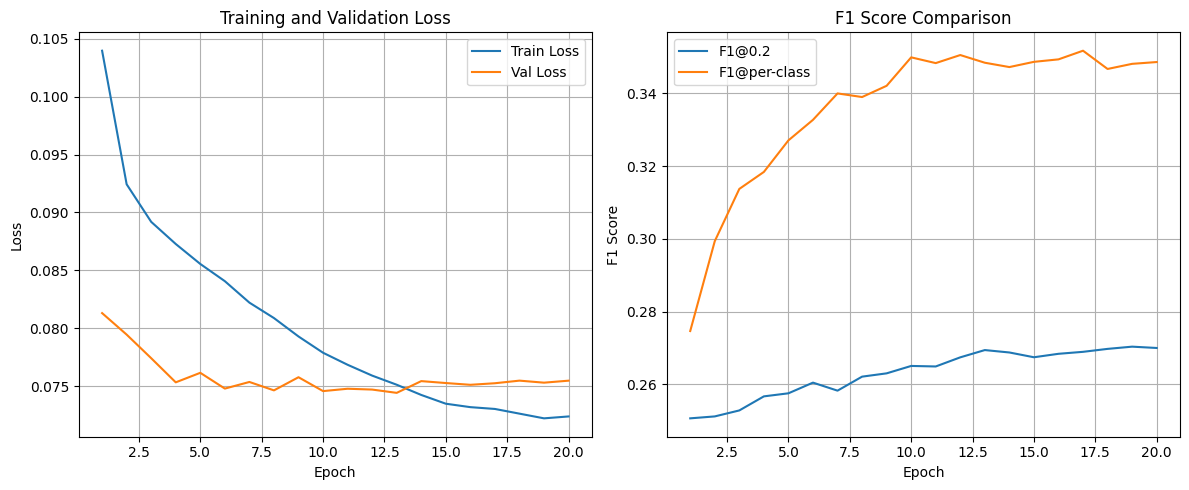


Multilabel Confusion Matrix:

Label: Atelectasis
[[2692 3755]
 [ 354 1864]]

Label: Cardiomegaly
[[7403  682]
 [ 342  238]]

Label: Consolidation
[[4637 3102]
 [ 339  587]]

Label: Effusion
[[3910 2033]
 [ 867 1855]]

Label: Emphysema
[[7557  675]
 [ 239  194]]

Label: Fibrosis
[[6282 2039]
 [ 141  203]]

Label: Infiltration
[[ 418 4419]
 [ 179 3649]]

Label: Pneumonia
[[7939  478]
 [ 218   30]]

Label: Pneumothorax
[[6829  813]
 [ 593  430]]


In [54]:
def train():
    best_val_loss = float('inf')
    best_preds, best_labels = None, None

    train_losses = []
    val_losses = []
    val_f1_fixed = []      # F1@0.2
    val_f1_perclass = []   # F1 with per-class thresholds
    val_best_threshes = []

    for epoch in range(CONFIG["num_epochs"]):
        epoch_num = epoch + 1
        print(f"\n=== Epoch {epoch_num} ===")

        image_encoder.unfreeze_layers(epoch_num)

        if epoch_num >= 2:
            lab_encoder.unfreeze()
        else:
            lab_encoder.freeze()

        image_encoder.train()
        classifier.train()
        cross_attention.train()

        train_loss, *_ = run_epoch(
            model_components=(lab_encoder, image_encoder, classifier, cross_attention),
            data_loader=train_loader,
            optimizer=optimizer,
            scheduler=scheduler,
            criterion=criterion,
            is_train=True,
            use_lab=(epoch_num >= 2)
        )

        val_loss, f1_fixed, f1_perclass, best_threshes, val_labels, val_preds = evaluate()
        val_best_threshes.append(best_threshes)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_f1_fixed.append(f1_fixed)
        val_f1_perclass.append(f1_perclass)

        print(f"Epoch {epoch_num}: "
              f"Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f} "
              f"| F1@0.2 = {f1_fixed:.4f} | F1@per-class = {f1_perclass:.4f}")

        # Save best model (by validation loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_preds = val_preds
            best_labels = val_labels
            torch.save({
                'lab_encoder': lab_encoder.state_dict(),
                'image_encoder': image_encoder.state_dict(),
                'classifier': classifier.state_dict(),
                'cross_attention': cross_attention.state_dict(),
                'best_thresholds': best_threshes
            }, 'best_model_labs.pth')
            print("Saved new best model!")

    # Final metrics and plots
    print("\n Final Metrics ")
    exact_match_acc = (best_labels == best_preds).all(axis=1).mean()
    print(f"Multilabel Accuracy (Exact Match): {exact_match_acc:.4f}")
    print(classification_report(best_labels, best_preds, target_names=label_list, zero_division=0))

    plot_training_curves(train_losses, val_losses, val_f1_fixed, val_f1_perclass)
    plot_confusion_matrices(best_labels, best_preds)


if __name__ == "__main__":
    set_seed(42)
    train()

    artifacts = {
        'test_name_to_idx':   test_name_to_idx,
        'test_statistics':    test_stats, 
        'test_columns':       test_cols,
        'value_columns':      value_cols,
        'label_list':         label_list,
        'test_name_embeddings': lab_encoder.test_name_embedding.weight
                                  .detach().cpu(),
        'hidden_dim':         CONFIG['hidden_dim'],
        'fusion_mode':        CONFIG['fusion_mode'],
        'use_attention':      CONFIG['use_attention'],
    }
    torch.save(artifacts, 'lab_artifacts.pth')

In [63]:
def test_model(lab_encoder, image_encoder, cross_attention, classifier,
               test_loader, criterion, device, label_list, thresholds=None):

    lab_encoder.eval()
    image_encoder.eval()
    cross_attention.eval()
    classifier.eval()

    all_preds = []
    all_labels = []
    total_test_loss = 0

    with torch.no_grad():
        for labels, images, attn_masks, lab_test_indices, lab_values in tqdm(
                test_loader, desc="Testing"):

            labels = labels.to(device)
            images = images.to(device)
            attn_masks = attn_masks.to(device)
            lab_test_indices = lab_test_indices.to(device)
            lab_values = lab_values.to(device)

            lab_embs = lab_encoder(lab_test_indices, lab_values)
            image_embs = image_encoder(images)
            fused_embs = cross_attention(
                image_embs,
                lab_embs,
                mask=attn_masks,
                lab_test_indices=lab_test_indices,
                lab_values=lab_values
            )
            logits = classifier(fused_embs)
            loss = criterion(logits, labels)
            total_test_loss += loss.item()

            probs = torch.sigmoid(logits).cpu()
            if thresholds is not None:
                # thresholds: list/array длины num_classes
                thr = torch.tensor(thresholds).unsqueeze(0)
                preds = (probs > thr).long()
            else:
                preds = (probs > 0.3).long()

            all_preds.append(preds)
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    avg_test_loss = total_test_loss / len(test_loader)
    test_f1 = f1_score(all_labels.numpy(), all_preds.numpy(),
                       average='macro', zero_division=0)

    print("\n=== Test Set Results ===")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test F1 Score (Macro): {test_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(
        all_labels.numpy(),
        all_preds.numpy(),
        target_names=label_list,
        zero_division=0
    ))

    cm = multilabel_confusion_matrix(
        all_labels.numpy(), all_preds.numpy()
    )
    for idx, label in enumerate(label2idx.keys()):
        print(f"\nLabel: {label}")
        print(cm[idx])


    return avg_test_loss, test_f1

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   
        std=[0.229, 0.224, 0.225]
    )
])

test_list_path = '/kaggle/input/nih-chest-x-ray-14-224x224-resized/test_list_NIH.txt'
with open(test_list_path) as f:
    test_list = set(line.strip() for line in f)

df_test = full_df[full_df['image'].isin(test_list)].reset_index(drop=True)

test_dataset = SequentialLabTestDataset(
    df=df_test,
    label2idx=label2idx,
    image_dir=PATHS["images"],
    num_classes=len(label_list),
    test_statistics=test_stats,
    test_columns=test_cols,
    value_columns=value_cols,
    load_images=True,
    transform=test_transforms    
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    collate_fn=partial(custom_collate, top_tests_to_idx=test_name_to_idx),
    num_workers=4,
    pin_memory=True
)

from numpy.core.multiarray import _reconstruct
from numpy import ndarray, dtype
from numpy.dtypes import Float64DType

torch.serialization.add_safe_globals([_reconstruct, ndarray, dtype, Float64DType])

ckpt = torch.load('best_model_labs.pth', map_location=CONFIG["device"], weights_only=True)
lab_encoder.load_state_dict(ckpt['lab_encoder'])
image_encoder.load_state_dict(ckpt['image_encoder'])
cross_attention.load_state_dict(ckpt['cross_attention'])  
classifier.load_state_dict(ckpt['classifier'])
best_thresholds = ckpt['best_thresholds']

print("1) Testing with FIXED threshold = 0.3 ")
fixed_loss, fixed_f1 = test_model(
    lab_encoder=lab_encoder,
    image_encoder=image_encoder,
    cross_attention=cross_attention,
    classifier=classifier,
    test_loader=test_loader,
    criterion=criterion,
    device=CONFIG["device"],
    label_list=label_list,
    thresholds=None
)

print("\n 2) Testing with BEST per-class thresholds ")
best_loss, best_f1 = test_model(
    lab_encoder=lab_encoder,
    image_encoder=image_encoder,
    cross_attention=cross_attention,
    classifier=classifier,
    test_loader=test_loader,
    criterion=criterion,
    device=CONFIG["device"],
    label_list=label_list,
    thresholds=best_thresholds
)

print("\n FINAL COMPARISON ")


1) Testing with FIXED threshold = 0.3 


Testing: 100%|██████████| 491/491 [00:30<00:00, 16.30it/s]



=== Test Set Results ===
Test Loss: 0.0700
Test F1 Score (Macro): 0.3350

Classification Report:
               precision    recall  f1-score   support

  Atelectasis       0.24      0.95      0.38      3255
 Cardiomegaly       0.19      0.82      0.31      1065
Consolidation       0.14      0.92      0.25      1815
     Effusion       0.32      0.97      0.48      4648
    Emphysema       0.18      0.87      0.30      1093
     Fibrosis       0.11      0.77      0.19       435
 Infiltration       0.39      1.00      0.56      6088
    Pneumonia       0.06      0.83      0.11       477
 Pneumothorax       0.30      0.87      0.45      2661

    micro avg       0.25      0.94      0.39     21537
    macro avg       0.21      0.89      0.33     21537
 weighted avg       0.29      0.94      0.43     21537
  samples avg       0.25      0.84      0.37     21537


Label: Atelectasis
[[ 2373 10056]
 [  155  3100]]

Label: Cardiomegaly
[[10863  3756]
 [  197   868]]

Label: Consolidation
[[ 3

Testing: 100%|██████████| 491/491 [00:30<00:00, 16.28it/s]



=== Test Set Results ===
Test Loss: 0.0700
Test F1 Score (Macro): 0.3943

Classification Report:
               precision    recall  f1-score   support

  Atelectasis       0.28      0.82      0.41      3255
 Cardiomegaly       0.36      0.52      0.43      1065
Consolidation       0.17      0.73      0.28      1815
     Effusion       0.43      0.73      0.54      4648
    Emphysema       0.32      0.64      0.42      1093
     Fibrosis       0.11      0.77      0.19       435
 Infiltration       0.40      0.97      0.57      6088
    Pneumonia       0.13      0.33      0.18       477
 Pneumothorax       0.46      0.60      0.52      2661

    micro avg       0.32      0.77      0.46     21537
    macro avg       0.30      0.68      0.39     21537
 weighted avg       0.36      0.77      0.48     21537
  samples avg       0.33      0.69      0.42     21537


Label: Atelectasis
[[5390 7039]
 [ 579 2676]]

Label: Cardiomegaly
[[13639   980]
 [  507   558]]

Label: Consolidation
[[7459 6